# Analisi della serie temporale delle misure di peso

Le misure sono state salvate per mezzo della app [*Simple Weight Tracker*](https://play.google.com/store/apps/details?id=com.gmail.makasewicz.maciej&hl=en_US) dal Novembre 2017.

### Caricamento le librerie necessarie

In [1]:
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(library(lubridate))
library(lomb)
suppressMessages(library(gridExtra))

### Importazione dei dati e preparazione per l'analisi

In [2]:
dt = read.csv("data/SWT_EXPORT_11_15_20_13_40.csv", 
              header = TRUE, 
              colClasses=c('Date','numeric'))
dt <- dt %>% 
    mutate(time=as.POSIXct(Date,format="%Y-%m-%d")) %>%
    mutate(dayWeek=weekdays(Date)) %>%
    mutate(MonthName=months(Date)) %>%
    mutate(Month=month(Date)) %>%
    mutate(Year=year(Date)) %>%
    mutate(Week=week(Date)) %>%
    mutate(MonthYear=as.factor(format(Date,"%Y-%m"))) %>%
    mutate(YearWeek=as.factor(paste(as.character(Year),
                                    as.character(Week),sep='-')))
dt$dayWeek <- factor(dt$dayWeek, levels= c("Monday", 
    "Tuesday", "Wednesday", "Thursday", "Friday", 
    "Saturday", "Sunday"))
dt$MonthName <- factor(dt$MonthName, levels= c("January", 
    "February", "March", "April", "May",  
    "June", "July", "August", "September", 
    "October", "November", "December"))
dt$Year <- as.factor(dt$Year)

### Sommario della distribuzione dei pesi
numero di misure per giorno della settimana, mese e anno.

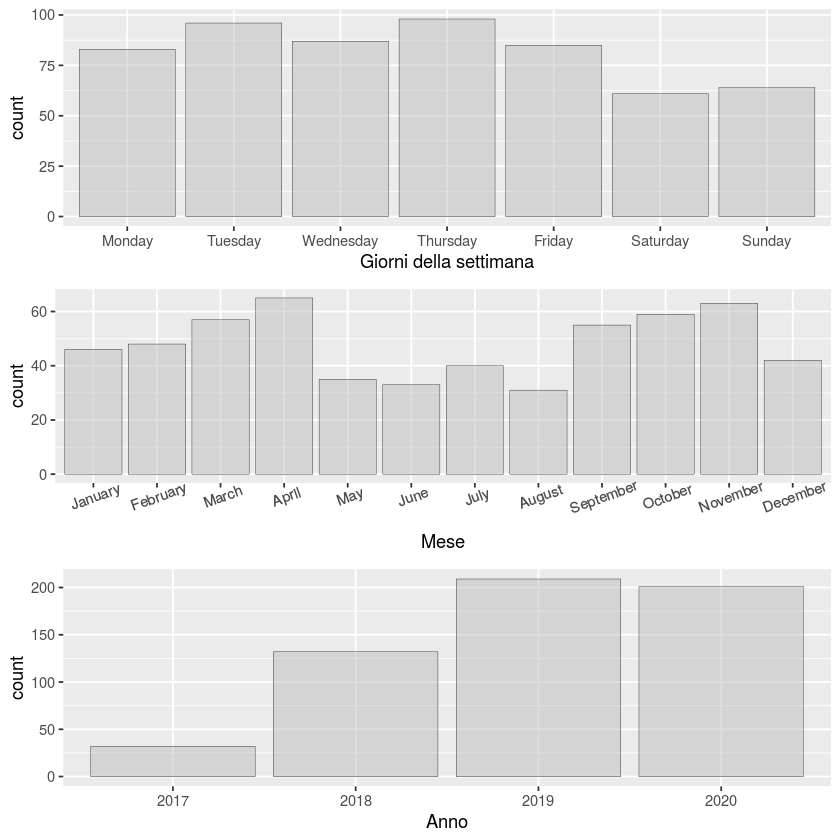

In [3]:
p1 <- dt %>%
    ggplot(mapping = aes(x=dayWeek)) +
    geom_bar(color = "black", size = 0.1, fill = "grey", alpha = 0.5) +
    xlab("Giorni della settimana")
p2 <- dt %>%
    ggplot(mapping = aes(x=MonthName)) +
    geom_bar(color = "black", size = 0.1, fill = "grey", alpha = 0.5) +
    xlab("Mese") +
    theme(axis.text.x = element_text(angle=20))
p3 <- dt %>%
    ggplot(mapping = aes(x=Year)) +
    geom_bar(color = "black", size = 0.1, fill = "grey", alpha = 0.5) +
    xlab("Anno")
grid.arrange(p1, p2, p3, nrow=3)

### Distribuzione dei pesi

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  68.30   71.40   73.00   73.45   75.68   78.90 

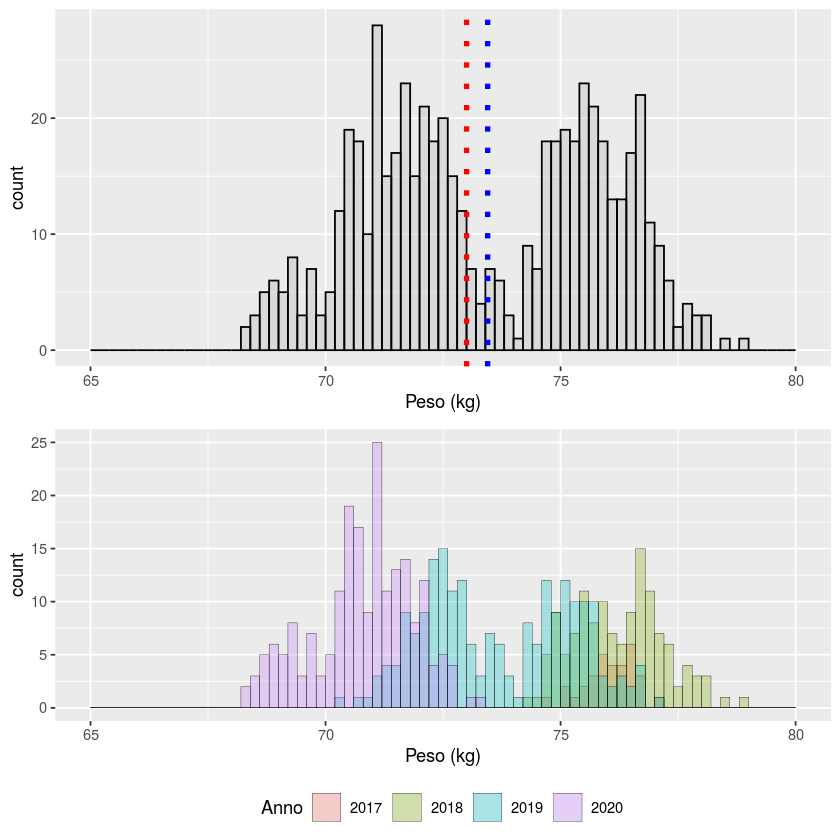

In [6]:
summary(dt[,"Weight"])
p1 <- dt %>% ggplot(aes(x=Weight)) +
    geom_histogram(alpha=0.4, 
                   color = "black", 
                   fill = "gray", 
                   size = 0.5, 
                   breaks = seq(from = 65, to = 80, by = 0.2)) + 
    xlab("Peso (kg)") +
    scale_x_continuous(limits = c(65, 80)) +
    geom_vline(xintercept = mean(dt[,"Weight"]), 
               linetype="dotted", 
               color = "blue", 
               size=1.5) +
    geom_vline(xintercept = median(dt[,"Weight"]), 
               linetype="dotted", 
               color = "red", 
               size=1.5)

p2 <- dt %>% ggplot(aes(x=Weight, fill=Year)) +
    geom_histogram(position="Identity", 
                   alpha=0.3, 
                   size = 0.1, 
                   color = "black",
                   breaks = seq(from = 65, to = 80, by = 0.2)) + 
    xlab("Peso (kg)") + 
    scale_fill_discrete(name='Anno') +
    theme(legend.position="bottom")
grid.arrange(p1, p2, nrow=2)

### Peso in funzione della data

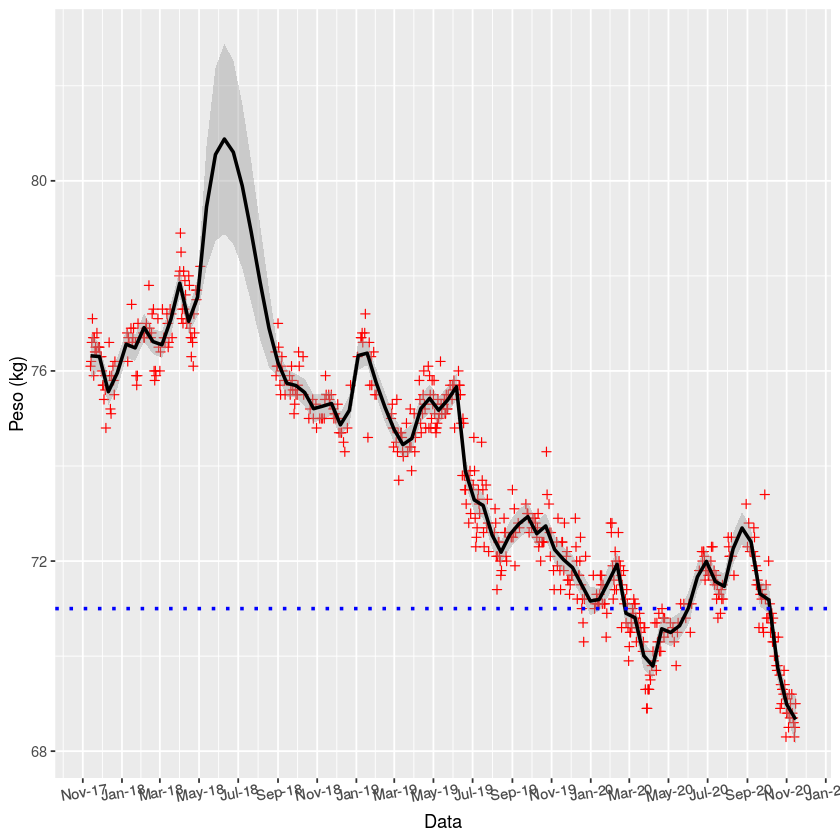

In [7]:
ggplot(data=dt, mapping = aes(x = Date, y = Weight)) + 
 ylab("Peso (kg)") + 
 xlab("Data") + 
 geom_point(shape=3, color = "red") +
 geom_smooth(method = "loess", span = 0.05, color = "black") +
 theme(axis.text.x = element_text(angle=10)) +
 scale_x_date(date_breaks = "2 month", date_labels = "%b-%y") +
 geom_hline(yintercept = 71, linetype="dotted", 
                color = "blue", size=1.)

### Peso per anno

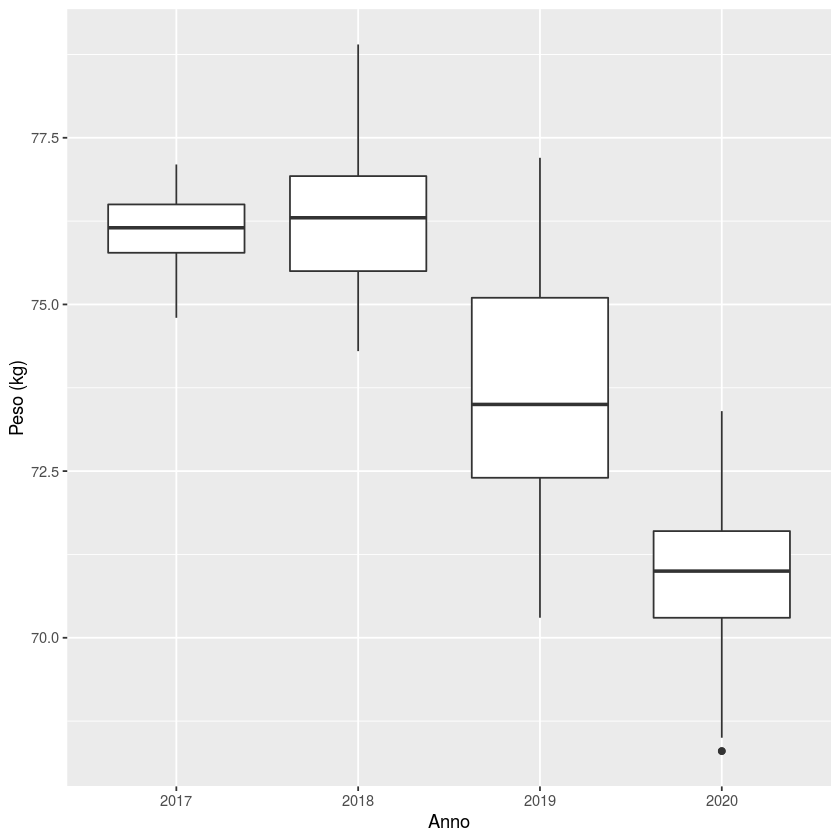

In [8]:
dt %>% ggplot(aes(x=Year,y=Weight)) +
    geom_boxplot() +
    xlab("Anno") +
    ylab("Peso (kg)")

### Scarto del peso rispetto alla media annuale in funzione del mese

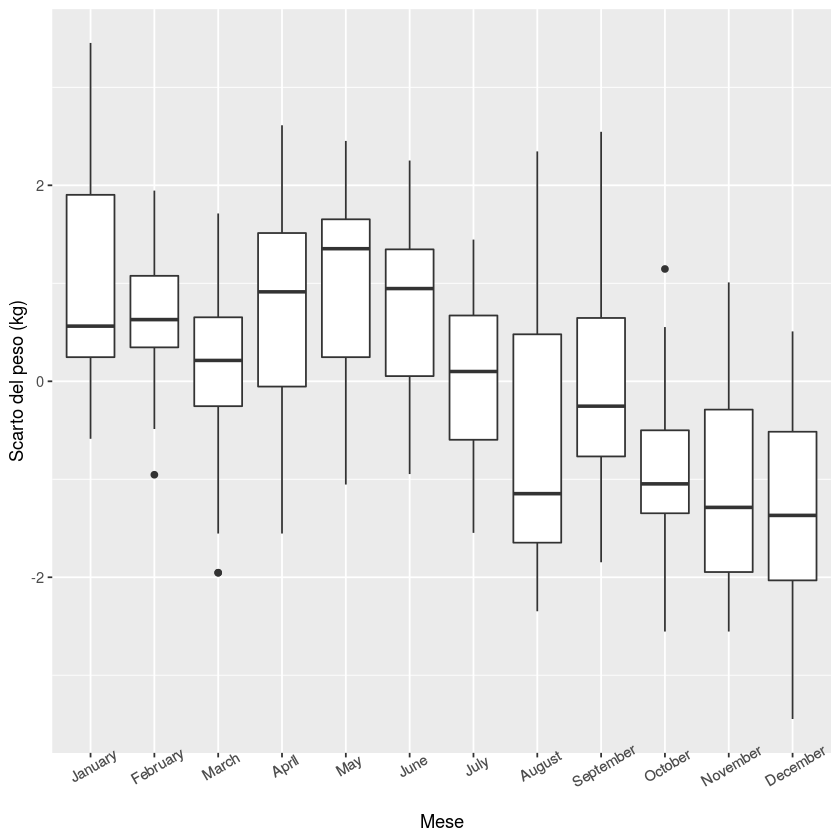

In [9]:
itable <- dt[,c("Weight","MonthName","Year")]
table <- itable[0,]

for(y in unique(itable[,"Year"]))
    table <- rbind(table,
                   mutate(filter(itable, Year == y),
                          delta = Weight - 
                          mean(filter(itable, Year == y)[,"Weight"])))

table %>%
    ggplot() + geom_boxplot(mapping = aes(x = MonthName, 
                                          y = delta)) + 
    xlab("Mese") + 
    ylab("Scarto del peso (kg)")+
    theme(axis.text.x = element_text(angle=30))

### Scarto del peso rispetto alla media settimanale in funzione del giorno della settimana

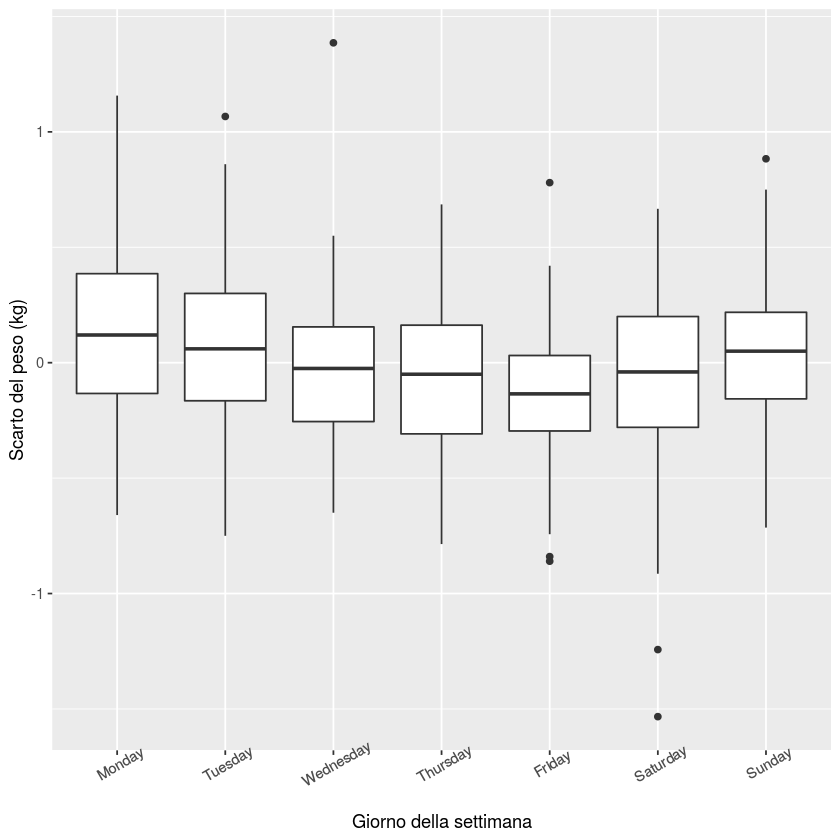

In [8]:
itable <- dt[,c("Weight","dayWeek","Week","YearWeek")]
table <- itable[0,]

for(yw in unique(itable[,"YearWeek"]))
    table <- rbind(table,
                   mutate(filter(itable, YearWeek == yw),
                          delta = Weight - 
                          mean(filter(itable,
                                      YearWeek == yw)[,"Weight"])))

table %>%
    ggplot() + geom_boxplot(mapping = aes(x = dayWeek, 
                                          y = delta
                                         )) + 
    xlab("Giorno della settimana") + 
    ylab("Scarto del peso (kg)")+
    theme(axis.text.x = element_text(angle=30))

### Lomb-Scargle Periodogram

[1] 266.666667 200.000000 133.333333  72.727273  66.666667  50.000000
 [7]  47.058824  28.571429  27.586207  26.666667  25.806452   6.896552

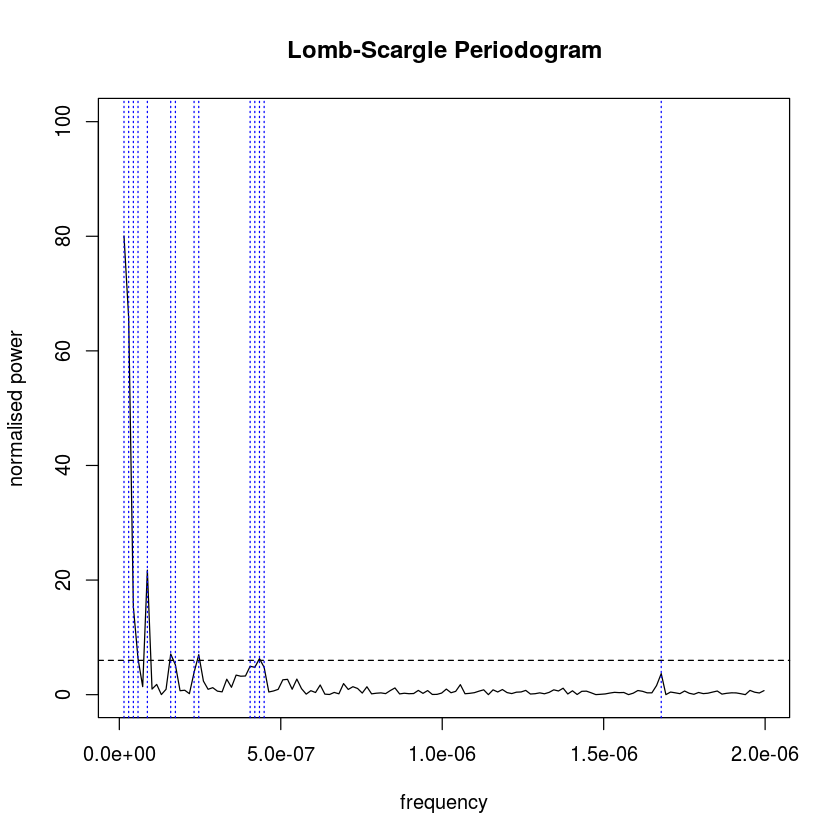

In [103]:
plot <- lsp(dt[,c("time","Weight")], 
            type = "frequency", 
            from = 1e-8, 
            to = 2e-6, 
            alpha = 0.5)
power <- unlist(plot["power"], use.names=FALSE)
scanned <- unlist(plot["scanned"], use.names=FALSE)
freq <- scanned[which(power>3.6)]
abline(v=freq, 
       col=rep("blue",times = length(freq)), 
       lty=rep(3,times = length(freq)), 
       lwd=rep(1,times = length(freq)))
periods <- 1/freq/60/60/24

